## IDs:
ID 1: 204502926 <br>
ID 2: 039065313

## Imports:

In [1]:
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from numpy.linalg import solve

np.random.seed(0)

### Question 1: Data exploration (15 points)

#### Answer:

In [2]:
def make_histogram(dataset, attribute, bins=25, bar_color='#3498db', edge_color='#2980b9', title='Title', xlab='X', ylab='Y', sort_index=False): 
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=24, pad=5, bbox={'facecolor':'k', 'pad':5},color='w')
    ax.set_xlabel(xlab, fontsize=16, labelpad=10)
    ax.set_ylabel(ylab, fontsize=16, labelpad=20)
    plt.xticks(rotation=45)
    plt.hist(dataset[attribute], bins=50, color=bar_color, ec=edge_color, linewidth=2)

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Sparsity: 0.9369533063577546



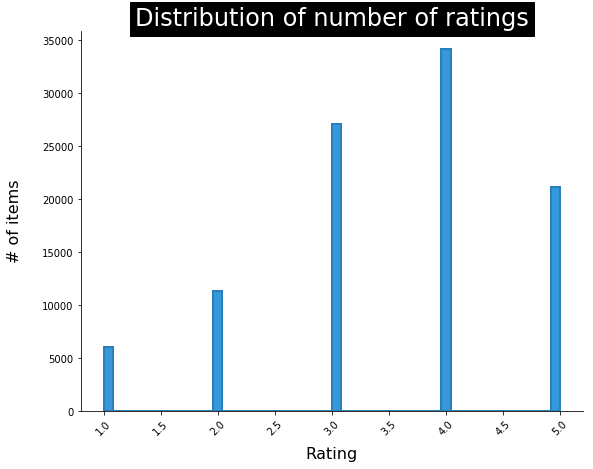

In [3]:
# Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item. 
# Include additional exploration you find relevant to questions 2 and 3.
# Discuss your insights and possible challenges related to the prediction task described in question 2.


# Remember that sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (movies). 
# In other words, dividing the number of ratings present in the matrix by the product of users and movies in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

file_path = 'ml-100k/u.data' # grouplens.org/datasets/movielens/100k

names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(file_path, sep='\t', names=names)

print(data.head())

all_users_ids = data.user_id.unique()
all_items_ids = data.item_id.unique()
ratings_count = data.shape[0] # 100,000
users_count = len(all_users_ids)
items_count = len(all_items_ids)
sparsity = 1 - (ratings_count / (users_count * items_count))
print(f'Sparsity: {sparsity}')
print()


make_histogram(data, 'rating', title='Distribution of number of ratings', xlab='Rating', ylab='# of items')

We can see that **'4'** is the dominant rating (34,174 ratings)<br>
The average rating is: $\frac{\sum_{i=1}^n(i * y(i))}{|S|}$, where i is a rating value (1-5), y(i) is the amount of ratings per user/item, and |S| is the size of the dataset (100K).<br>
We can also see that the users are more prone to give a perfect rating ('5') rather than < '3'.

In [4]:
average = sum(data['rating']) / len(data['rating'])
print(f'The average rating is {average}')

The average rating is 3.52986



### Question 2: Matrix factorization model implementation and evaluation (60 points)

#### Answer:

In [5]:
def create_rating_matrix_from_raw_data(df):
    ratings = np.zeros((all_users_ids.shape[0], all_items_ids.shape[0]))

    for row in df.itertuples():
        ratings[row[1]-1][row[2]-1] = row[3]  
        
    return ratings

In [6]:
ratings = create_rating_matrix_from_raw_data(data)
# ratings.shape

In [7]:
def get_5_folds(folds_dir='./ml-100k/'):
    
    
    
    
    
#     change to 5!!!!!!!






    number_of_folds = 2
    header = ['user_id', 'item_id', 'rating', 'timestamp']
    folds = []
    
    for i in range(number_of_folds):     
        print(f'{folds_dir}u{i+1}.base')
        
        df_train = pd.read_csv(f'{folds_dir}u{i+1}.base', sep='\t', names=header)
        df_test = pd.read_csv(f'{folds_dir}u{i+1}.test', sep='\t', names=header)   
        
        rating_train = create_rating_matrix_from_raw_data(df_train)
        rating_test  = create_rating_matrix_from_raw_data(df_test)        
           
        folds.append((rating_train, rating_test))
        
    return folds


folds = get_5_folds()

for fold in folds:
    print(fold[0].shape, fold[1].shape)

./ml-100k/u1.base
./ml-100k/u2.base
(943, 1682) (943, 1682)
(943, 1682) (943, 1682)


In [8]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    
    return mean_squared_error(pred, actual)

In [9]:
class ExplicitMFSGD():
    def __init__(self, 
                 ratings,
                 k_factors = 40,
                 item_fact_reg = 0.0, 
                 user_fact_reg = 0.0,
                 item_bias_reg = 0.0,
                 user_bias_reg = 0.0,
                 verbose = False):
        """
        Train a matrix factorization model to predict empty entries in a matrix. 
        The terminology assumes a ratings matrix which is ~ user x item.
        
        (To avoid overfitting we use regularization)

        Params
        ======
        ratings: (ndarray)
            User x Item matrix with corresponding ratings
        
        k_factors: (int)
            Number of latent factors to use in matrix factorization model
        
        item_fact_reg: (float)
            Regularization term for item latent factors
            
        user_fact_reg: (float)
            Regularization term for user latent factors
            
        item_bias_reg: (float)
            Regularization term for item biases
        
        user_bias_reg: (float)
            Regularization term for user biases
        
        verbose: (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.users_count = users_count
        self.items_count = items_count
        self.k_factors = k_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        self._v = verbose
        self.curr_iter = 1

        
    def calculate_learning_curve(self, iter_array, test, learning_rate):
        iter_array.sort()
        self.init_for_train(learning_rate)
        training_mse, test_mse = [], []
        
        for n_iter in iter_array:            
            self.print_verbose(f'k={self.k_factors}, alpha={learning_rate}, '\
                              f'iterations={n_iter}, item_fact_reg={self.item_fact_reg}, '\
                              f'user_fact_reg={self.user_fact_reg}, item_bias_reg={self.item_bias_reg}, '\
                              f'user_bias_reg={self.user_bias_reg}')
            self.train(n_iter)
            predictions = self.get_prediction_matrix()
            self.evaluate(predictions, training_mse, test_mse, test)
            
        print('======================')
        
        return training_mse, test_mse
    
    
    def init_for_train(self, learning_rate=0.1):        
        # initialize latent vectors
        # Approximate rating matrix by product of lower rank matrix
        self.user_vecs = np.random.normal(scale=1./self.k_factors, size=(self.users_count, self.k_factors))
        self.item_vecs = np.random.normal(scale=1./self.k_factors, size=(self.items_count, self.k_factors))
        
        self.learning_rate = learning_rate
        self.user_bias = np.zeros(self.users_count)
        self.item_bias = np.zeros(self.items_count)
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])

    def train(self, n_iter):
        """ 
        Train model for n_iter iterations. 
        Can be called multiple times for further training.
        """
        while self.curr_iter <= n_iter:
            if self.curr_iter % 10 == 0 and n_iter > 10 and self._v:
                print(f'\tStill running...')
                print(f'\tCurrent iteration: {self.curr_iter}')
                
            self.training_indices = np.arange(self.n_samples)
            np.random.shuffle(self.training_indices)
            self.perform_sgd()
            self.curr_iter += 1
            
    def predict(self, user, item):
        """
        Single user and item prediction
        """
        biases = self.global_bias + self.user_bias[user] + self.item_bias[item]
        prediction_value = biases + self.user_vecs[user, :].dot(self.item_vecs[item, :].T)
        
        return prediction_value
    
    def perform_sgd(self):
        for idx in self.training_indices:
            user = self.sample_row[idx]
            item = self.sample_col[idx]
            prediction = self.predict(user, item)
            actual_rating = self.ratings[user, item] # get actual rating from the dataset's ratings array 
            error = actual_rating - prediction
            
            # Update biases
            self.user_bias[user] += self.learning_rate * (error - self.user_bias_reg * self.user_bias[user])
            self.item_bias[item] += self.learning_rate * (error - self.item_bias_reg * self.item_bias[item])
            
            # Update latent factors
            self.user_vecs[user, :] += self.learning_rate * (error * self.item_vecs[item, :] - self.user_fact_reg * self.user_vecs[user,:])
            self.item_vecs[item, :] += self.learning_rate * (error * self.user_vecs[user, :] - self.item_fact_reg * self.item_vecs[item,:])
    
    def get_prediction_matrix(self):
        """
        Predict ratings for every user and item
        """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        
        for user in range(self.user_vecs.shape[0]):
            for item in range(self.item_vecs.shape[0]):
                predictions[user, item] = self.predict(user, item)
                
        return predictions
    
    def evaluate(self, predictions, training_mse, test_mse, test):
        training_mse.append(get_mse(predictions, self.ratings))
        test_mse.append(get_mse(predictions, test))

        self.print_verbose(f'Training MSE = {training_mse[-1]}')
        self.print_verbose(f'Test MSE = {test_mse[-1]}')

    def print_verbose(self, msg):
        if self._v:
            print(msg)

In [10]:
# sns.set()

# def plot_learning_curve(iter_array, model, k, learning_rate):
#     plt.figure(num=None, figsize=(8, 4), dpi=80, facecolor='w', edgecolor='k')

#     plt.plot(iter_array, model.training_mse, label=f"Training k={{{0}}}, alpha={{{1}}}".format(k, learning_rate), linewidth=5)
#     plt.plot(iter_array, model.test_mse, label=f"Test k={{{0}}}, alpha={{{1}}}".format(k, learning_rate), linewidth=5)

#     plt.xticks(fontsize=16);
#     plt.yticks(fontsize=16);
#     plt.xlabel('iterations', fontsize=30);
#     plt.ylabel('MSE', fontsize=30);
#     plt.legend(loc='best', fontsize=20);

In [11]:
sns.set()

def plot_learning_curve_list(iter_array, predictions, title, mse_extractor):
    plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

    for prediction in predictions:
        k, learning_rate = prediction["k"], prediction["learning_rate"]
        plt.plot(iter_array, mse_extractor(prediction), label=f"{title} k={k}, alpha={learning_rate}", linewidth=5)

    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
#     plt.title(title)
    plt.legend(loc='best', fontsize=20);

In [12]:
import copy
from itertools import combinations, combinations_with_replacement, permutations


def permutation_regularization_generator(base_dict):
#     regularization_parameters_values = [100.0, 10.0, 1.0, 0.0, 0.1, 0.01, 0.0001]
    regularization_parameters_values = [100.0]
    regularization_permutations = set()
    number_of_regularization_params = len(base_dict)
    
    for seq in list(combinations_with_replacement(regularization_parameters_values, number_of_regularization_params)):
        for perm_seq in permutations(seq, number_of_regularization_params):
            regularization_permutations.add(perm_seq)

    regularization_parameters_dict_list = []      
    keys = base_dict.keys()
    
    for perm in regularization_permutations:
        curr_values_dict = copy.deepcopy(base_dict)
        
        for idx, key in enumerate(keys):
            curr_values_dict[key] = perm[idx]
        
        regularization_parameters_dict_list.append(curr_values_dict)
        
    return regularization_parameters_dict_list

In [13]:
def generate_list_of_regularization_parameters_values(model_type):
    if model_type == "als":
        base_dict = {'item_reg': 0.0, 'user_reg':0.0}
    else: # model type == "sgd"
        base_dict = {'item_fact_reg': 0.0, 'user_fact_reg': 0.0, 'item_bias_reg': 0.0, 'user_bias_reg':0.0}
        
    return permutation_regularization_generator(base_dict)        

    
def als_model_provider(**params):
    return ExplicitMFALS(**params)


def sgd_model_provider(**params):
    return ExplicitMFSGD(**params)

In [14]:
# CODE EXAMPLE ON HOW I PASSED PARAMS:

def y(a=0, b=1, c=2, d=3):
    print(f'a:{a}, b:{b}, c:{c}, d:{d}')
    
def x(**params):
    y(**params)
    
last_params = {'c': 35, 'd': 45}
x(a=10,b=20,**last_params)   

a:10, b:20, c:35, d:45


In [15]:
def calculate_learning_curve(training_data, test_data, model_provider, model_type="sgd"):
    k_options = [20, 30, 40, 70, 150]
    learning_rate_options = [0.001, 0.01, 0.1]
    iter_array = [1, 5, 10, 25, 50, 100, 200]
    regularization_parameters_values = generate_list_of_regularization_parameters_values(model_type)
#     print(regularization_parameters_values)
    
    k_options = [20]
    learning_rate_options = [0.001]
    iter_array = [1, 10, 25]

    hyper_param_learning_iter_num = len(k_options)*len(learning_rate_options)*len(regularization_parameters_values)
    print(f'Going to do {hyper_param_learning_iter_num} permutation on the model parameters')
    
    perm_count = 1
    params_and_results = []
    
    for k in k_options:
        for learning_rate in learning_rate_options:
            for regularization_parameters_value in regularization_parameters_values:    
                print(f'iteration {perm_count}/{hyper_param_learning_iter_num} ')
                model = model_provider(ratings=training_data, k_factors=k, verbose=True, **regularization_parameters_value)
                training_mse, test_mse = model.calculate_learning_curve(iter_array, test_data, learning_rate)
                curr_run_params_and_results = {"k": k, "learning_rate": learning_rate, "training_mse": training_mse, "test_mse": test_mse}
                params_and_results.append({**curr_run_params_and_results, **regularization_parameters_value})    
                perm_count += 1
                
    return params_and_results

## Train/Test/Collect ALS 5-folds

In [16]:
if False:
    als_folds_results = []
    
    for fold in folds:
        training_data, test_data = fold
        params_and_results = calculate_learning_curve(training_data, test_data, model_provider=als_model_provider, model_type="als")
        als_folds_results.append(params_and_results)

## Train/Test/Collect SGD 5-folds

In [17]:
sgd_folds_results = []

for idx, fold in enumerate(folds, start = 0):
    print(f'Running on fold {idx}/{len(folds) - 1}')
    training_data, test_data = fold
    params_and_results = calculate_learning_curve(training_data, test_data, model_provider=sgd_model_provider, model_type="sgd")
    sgd_folds_results.append(params_and_results)

Running on fold 0/1
Going to do 1 permutation on the model parameters
iteration 1/1 
k=20, alpha=0.001, iterations=1, item_fact_reg=100.0, user_fact_reg=100.0, item_bias_reg=100.0, user_bias_reg=100.0
Training MSE = 1.2425937873118829
Test MSE = 1.3221014125700028
k=20, alpha=0.001, iterations=10, item_fact_reg=100.0, user_fact_reg=100.0, item_bias_reg=100.0, user_bias_reg=100.0
Training MSE = 1.2421754864265517
Test MSE = 1.3216157405966278
k=20, alpha=0.001, iterations=25, item_fact_reg=100.0, user_fact_reg=100.0, item_bias_reg=100.0, user_bias_reg=100.0
	Still running...
	Current iteration: 20
Training MSE = 1.2420816739883451
Test MSE = 1.321381640851526
Running on fold 1/1
Going to do 1 permutation on the model parameters
iteration 1/1 
k=20, alpha=0.001, iterations=1, item_fact_reg=100.0, user_fact_reg=100.0, item_bias_reg=100.0, user_bias_reg=100.0
Training MSE = 1.2555149775272627
Test MSE = 1.2701138162477614
k=20, alpha=0.001, iterations=10, item_fact_reg=100.0, user_fact_reg

In [18]:
# k_options = [10, 40]
# learning_rate_options = [0.001, 0.01]
# iter_array = [1, 5, 10]

# k_options = [20, 30, 40, 70, 150]
# learning_rate_optiAons = [0.001, 0.01, 0.1]
# iter_array = [1, 5, 10, 25, 50, 100, 200]

# MF_SGD_list = []

# for k in k_options:
#     for learning_rate in learning_rate_options:
# #         for item_fact_reg
# #         for user_fact_reg
# #         for bias ???                 
#         model = ExplicitMFSGD(ratings=training_data, k_factors=k, verbose=True)
#         training_mse, test_mse = model.calculate_learning_curve(iter_array, test_data, learning_rate)
#         predictions.append({"k": k, "learning_rate:": learning_rate, "training_mse": training_mse, "test_mse": test_mse})

In [19]:
# predictions.append({"k": k, "learning_rate:": learning_rate, "training_mse": training_mse, "test_mse": test_mse})

# plot_learning_curve_list(iter_array, predictions, title='Training', mse_extractor=lambda model: model["training_mse"])
# plot_learning_curve_list(iter_array, predictions, title='Test', mse_extractor=lambda model: model["test_mse"])

In [23]:
# print(range(len(sgd_folds_results)))
# print(sgd_folds_results)

demo = []
demo.append([{'k': 9, 'training_mse': [9, 1, 2]}, {'training_mse': [3, 4, 5]}, {'training_mse': [6, 7, 8]}])
demo.append([{'training_mse': [9, 1, 2]}, {'training_mse': [3, 4, 5]}, {'training_mse': [6, 7, 8]}])

example = {'k': 20, 'learning_rate': 0.001, 'training_mse': [1.2425937873118829, 1.2421754864265517, 1.2420816739883451], 'test_mse': [1.3221014125700028, 1.3216157405966278, 1.321381640851526], 
           'item_fact_reg': 100.0, 'user_fact_reg': 100.0, 'item_bias_reg': 100.0, 'user_bias_reg': 100.0}

def generate_key(example):
    key = f"k_{example['k']}_lr_{example['learning_rate']}_if_{example['item_fact_reg']}_uf_{example['user_fact_reg']}_ib_{example['item_bias_reg']}_ub_{example['user_bias_reg']}"
    print(key)
    
    
generate_key(example)




# def get_average_fold_error_results(array):
#     average_error_result_per_fold = []    
#     sum = 0
#     for i in range(len(array) + 1):
#         print(f'i: {i}')
        
#         for j in array:
#             print(j[i].get('training_mse'))
#             print(range(len(j[i].get('training_mse'))))
            
#             for k in range(len(j[i].get('training_mse'))):
#                 print(f"k: {j[i].get('training_mse')[k]}")
#                 sum += j[i].get('training_mse')[k]
#                 print(f'sum: {sum}')
#                 break
                
#             sum /= 


# get_average_fold_error_results(demo)

k_20_lr_0.001_if_100.0_uf_100.0_ib_100.0_ub_100.0


In [24]:
from collections import defaultdict

ohad = defaultdict(list)

for i in range(10):
    ohad[i].append(i)
    
ohad

defaultdict(list,
            {0: [0],
             1: [1],
             2: [2],
             3: [3],
             4: [4],
             5: [5],
             6: [6],
             7: [7],
             8: [8],
             9: [9]})

In [22]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[0]
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
plt.title('training_mse')
plt.legend(loc='best', fontsize=20);

NameError: name 'MF_SGD_list' is not defined

<Figure size 800x640 with 0 Axes>

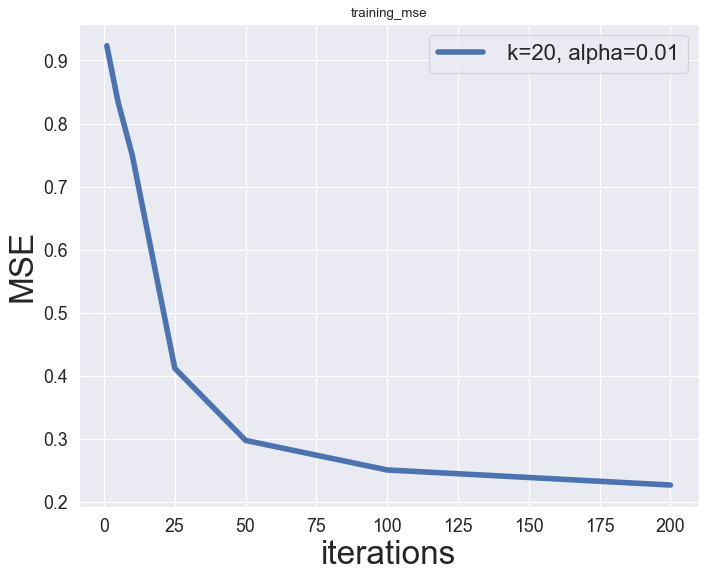

In [40]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[1]
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
plt.title('training_mse')
plt.legend(loc='best', fontsize=20);

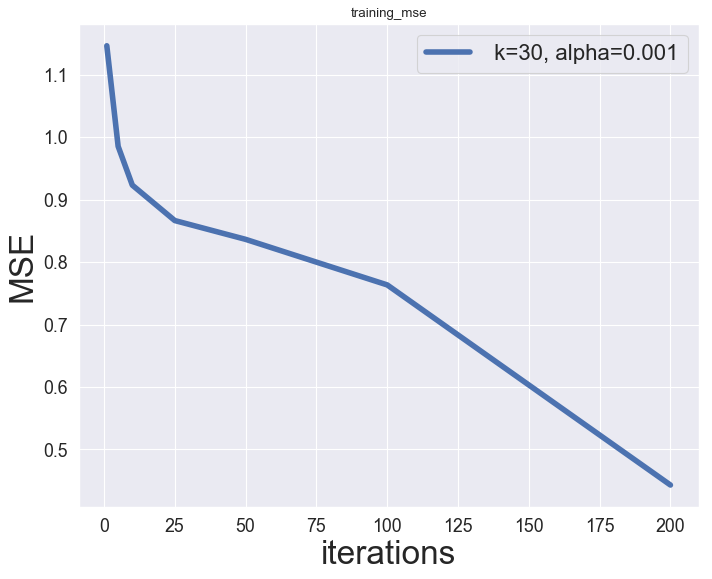

In [41]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[2]
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
plt.title('training_mse')
plt.legend(loc='best', fontsize=20);

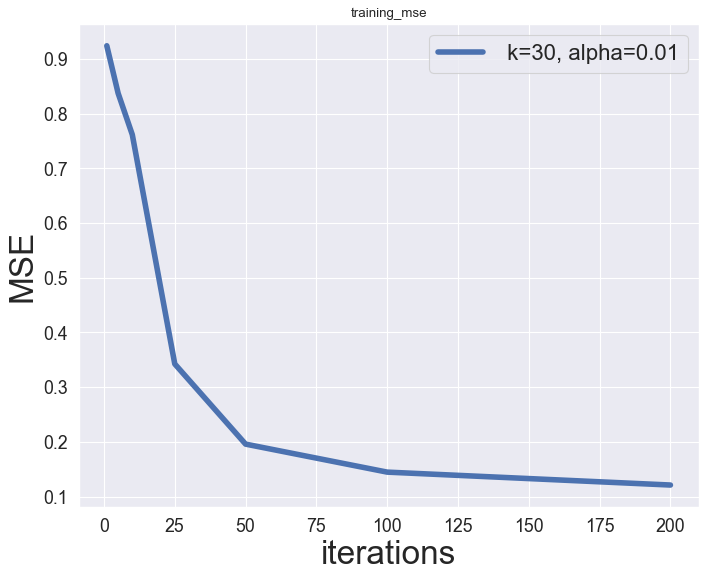

In [43]:
sns.set()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

model, k, learning_rate = MF_SGD_list[3]
plt.plot(iter_array, model.training_mse, label=f" k={k}, alpha={learning_rate}", linewidth=5)

plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('iterations', fontsize=30);
plt.ylabel('MSE', fontsize=30);
plt.title('training_mse')
plt.legend(loc='best', fontsize=20);

### Question 3: Matrix factorization – item similarity and model explainability (25 points)

#### Answer: